## Import Libraries

In [1]:
import folium
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopy
import datetime
from datetime import timedelta


from geopy.distance import geodesic
import random
from shapely.geometry import Point
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

import networkx as nx
from itertools import islice

## Data Cleaning and General Exploratory Analysis

In [2]:
df = pd.read_csv('trip_data.csv')
df.columns

Index(['route', 'trip_id', 'Datetime', 'city', 'state', 'Latitude',
       'Longitude'],
      dtype='object')

In [3]:
df.shape

(3532, 7)

In [4]:
df.head()

route trip_id                    Datetime  \
0         Dallas_Salt Lake City  Trip_1  2022-01-01 08:00:00.000000   
1          Portland_Los Angeles  Trip_1  2022-01-01 08:00:00.000000   
2  San Francisco_Salt Lake City  Trip_1  2022-01-01 08:00:00.000000   
3           Phoenix_San Antonio  Trip_1  2022-01-01 08:00:00.000000   
4                Chicago_Dallas  Trip_1  2022-01-01 08:00:00.000000   

            city       state  Latitude  Longitude  
0         Dallas       Texas   32.7935   -96.7667  
1       Portland      Oregon   45.5371  -122.6500  
2  San Francisco  California   37.7558  -122.4449  
3        Phoenix     Arizona   33.5722  -112.0892  
4        Chicago    Illinois   41.8375   -87.6866

In [5]:
df.isna().sum()

route        0
trip_id      0
Datetime     0
city         0
state        0
Latitude     0
Longitude    0
dtype: int64

In [6]:
sup = pd.DataFrame(df.groupby(['route'])['trip_id'].nunique()).reset_index()
sup.columns = ['Route', 'Trip Count']
sup

Route  Trip Count
0                Chicago_Dallas          32
1         Dallas_Salt Lake City          23
2           Phoenix_San Antonio          25
3          Portland_Los Angeles          24
4  San Francisco_Salt Lake City          30

In [7]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [8]:
sup = df.groupby(['route', 'trip_id'])['Datetime'].agg(['min', 'max']).reset_index()
sup.columns = ['route', 'trip_id', 'start', 'end']

In [9]:
sup.head()

route  trip_id                      start  \
0  Chicago_Dallas   Trip_1 2022-01-01 08:00:00.000000   
1  Chicago_Dallas  Trip_10 2022-04-13 15:43:28.129130   
2  Chicago_Dallas  Trip_11 2022-04-25 07:13:30.284322   
3  Chicago_Dallas  Trip_12 2022-05-07 08:34:12.085985   
4  Chicago_Dallas  Trip_13 2022-05-18 06:55:31.591802   

                         end  
0 2022-01-11 03:09:59.458893  
1 2022-04-25 07:13:30.284322  
2 2022-05-07 08:34:12.085985  
3 2022-05-18 06:55:31.591802  
4 2022-05-30 12:22:08.569157

In [10]:
sup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   route    134 non-null    object        
 1   trip_id  134 non-null    object        
 2   start    134 non-null    datetime64[ns]
 3   end      134 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 4.3+ KB


In [11]:
sup['duration'] =(sup['end'] - sup['start']) /pd.Timedelta(hours=1)

In [12]:
sup.head()

route  trip_id                      start  \
0  Chicago_Dallas   Trip_1 2022-01-01 08:00:00.000000   
1  Chicago_Dallas  Trip_10 2022-04-13 15:43:28.129130   
2  Chicago_Dallas  Trip_11 2022-04-25 07:13:30.284322   
3  Chicago_Dallas  Trip_12 2022-05-07 08:34:12.085985   
4  Chicago_Dallas  Trip_13 2022-05-18 06:55:31.591802   

                         end    duration  
0 2022-01-11 03:09:59.458893  235.166516  
1 2022-04-25 07:13:30.284322  279.500599  
2 2022-05-07 08:34:12.085985  289.344945  
3 2022-05-18 06:55:31.591802  262.355418  
4 2022-05-30 12:22:08.569157  293.443605

In [13]:
sup.groupby(['route'])['duration'].agg(['min', 'mean', 'median', 'max'])

min        mean      median         max
route                                                                       
Chicago_Dallas                222.157440  278.209480  279.519386  326.668268
Dallas_Salt Lake City         344.825906  381.943901  376.643259  447.197857
Phoenix_San Antonio           293.307603  350.902083  346.729716  396.864800
Portland_Los Angeles          321.890226  363.038050  361.969458  417.665246
San Francisco_Salt Lake City  248.468625  291.628960  297.347429  317.654337

In [14]:
sup['route'].unique()

array(['Chicago_Dallas', 'Dallas_Salt Lake City', 'Phoenix_San Antonio',
       'Portland_Los Angeles', 'San Francisco_Salt Lake City'],
      dtype=object)

Text(0, 0.5, 'Count')

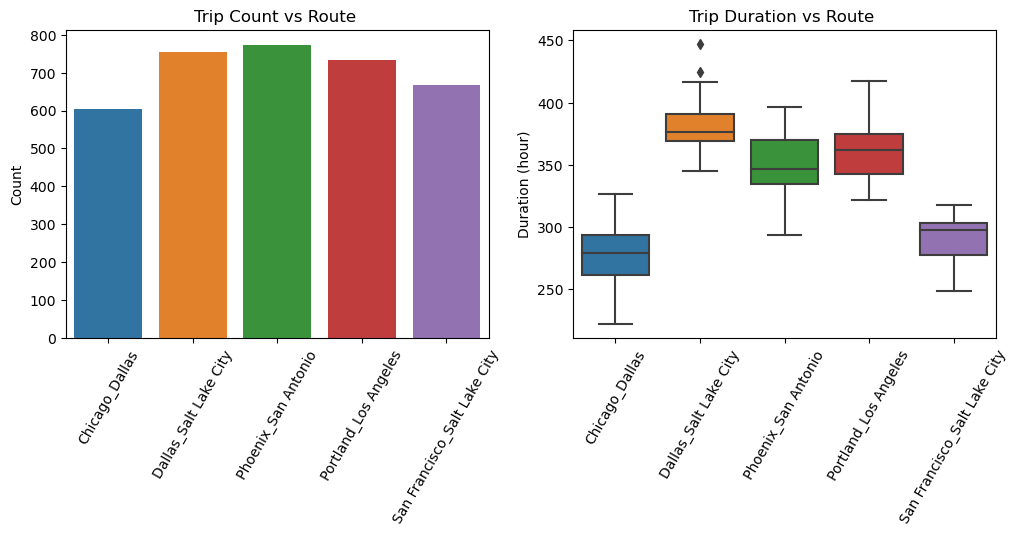

In [15]:
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(y='duration', x='route', data=sup, ax=ax1)
ax1.set_xlabel('')
ax1.set_xticks([0,1, 2, 3, 4])
ax1.set_xticklabels(['Chicago_Dallas', 'Dallas_Salt Lake City', 'Phoenix_San Antonio',
       'Portland_Los Angeles', 'San Francisco_Salt Lake City'], ha='center', rotation=60)

ax1.set_title('Trip Duration vs Route ')
ax1.set_ylabel('Duration (hour)')

sns.countplot(x='route', data=df, ax=ax0)
ax0.set_xlabel('')
ax0.set_xticks([0,1, 2, 3, 4])
ax0.set_xticklabels(['Chicago_Dallas', 'Dallas_Salt Lake City', 'Phoenix_San Antonio',
       'Portland_Los Angeles', 'San Francisco_Salt Lake City'], ha='center', rotation=60)

ax0.set_title('Trip Count vs Route ')
ax0.set_ylabel('Count')

In [16]:
fig.savefig('boxplot.png',  bbox_inches='tight')

## Visualize the stations and trips

In [17]:
trips = df['trip_id'].unique()

In [20]:
map_center = [37.97, -98.2]
map = folium.Map(width=800,height=500, location=map_center, zoom_start=4)
data = df.drop_duplicates(['Latitude', 'Longitude'])

for index, row in data.iterrows():
    station = [row['Latitude'], row['Longitude']]
    folium.Circle(r=1.5,location=station, popup=str(row['city']), color='black').add_to(map)

In [21]:
map

In [22]:
map_center = [37.97, -98.2]
map = folium.Map(width=800,height=500, location=map_center, zoom_start=4)
colors = ['blue','black', 'red', 'orange', 'purple']
df.sort_values(by='Datetime', inplace=True)

for path, col in zip(df['route'].unique(), colors):
    data  = df[df['route']==path]
    for i in range(1,len(data)):
        start = [data['Latitude'].iloc[i-1], data['Longitude'].iloc[i-1]]
        end = [data['Latitude'].iloc[i], data['Longitude'].iloc[i]]
        coord =[start, end]
        folium.vector_layers.PolyLine(coord, weight=0.5, color = col).add_to(map)
        folium.Circle(r=1.5,location=start, popup=str(data['city'].iloc[i-1]), color=col).add_to(map)
    
map

In [23]:
df['Point'] = [Point(y,x) for x, y in zip(df['Latitude'], df['Longitude'])]

In [25]:
df['Point'] = [Point(y,x) for x, y in zip(df['Latitude'], df['Longitude'])]
Origins = []
for city,st in zip(['Dallas', 'Portland', 'San Francisco', 'Phoenix', 'Chicago'],\
                   ['Texas', 'Oregon', 'California', 'Arizona', 'Illinois']):
    origin = df.loc[(df['city']==city) & (df['state']==st), 'Point'].unique()[0]
    Origins.append(origin)

In [26]:
routes =list(df['route'].unique())

In [27]:
Destinations = []
for city, st in zip(['Salt Lake City', 'Los Angeles', 'Salt Lake City', 'San Antonio', 'Dallas'], \
                    ['Utah', 'California', 'Utah', 'Texas', 'Texas']):
    destination = df.loc[(df['city']==city) & (df['state']==st), 'Point'].unique()[0]
    Destinations.append(destination)    

## First Approach: Finding the travelled route based on closeness

In [28]:
def route_finder(origin, destination, route): 
    path = [origin]
    data = df[(df['route']==route)]
    stops = list(data['Point'].unique())
    stops.remove(origin)
    stop0 = origin
    while len(stops)!= 0:
        distance_ = {}
        for stop in stops:
            distance_[stop] = stop.distance(stop0)
        next_stop = min(distance_, key=distance_.get)
        path.append(next_stop)    
        stops.remove(next_stop)
        stop0 = next_stop
    return path
        


In [29]:
Paths = []
for origin, destination, route in zip(Origins, Destinations, routes):
    path = route_finder(origin, destination, route)
    Paths.append([route, path])
    

In [30]:
map_center = [40.97, -100.2]
map = folium.Map(location=map_center, zoom_start=4)


for path in Paths:
    road = path[1]
    for i in range(0, len(road)):
        point = [road[i].y, road[i].x]
        folium.Circle(r=.01,location=point, popup=str(point),color='black', fill=True).add_to(map)
    for i in range(1,len(road)):
        start = [road[i-1].y, road[i-1].x]
        end = [road[i].y, road[i].x]
        coord=[start, end]
        folium.vector_layers.PolyLine(coord, weight=2, color = 'blue').add_to(map)
        
            
map

## Finding the route: Graph Theory


In [31]:
def add_edges_from_history(df):
    G = nx.Graph()
    # Group by railcar_id and origin-destination pair to process each railcar's travel history
    for (route, tripid), group in df.groupby(['route', 'trip_id']):
        group = group.sort_values(by='Datetime')
        locations = group['Point'].tolist()
        
        # Remove None values to handle missing messages
        locations = [loc for loc in locations if pd.notna(loc)]
        
        # Add edges between consecutive locations
        for i in range(len(locations) - 1):
            start = locations[i]
            end = locations[i + 1]
            if G.has_edge(start, end):
                G[start][end]['weight'] += 1  # Increment weight if edge already exists
            else:
                G.add_edge(start, end, weight=1)  # Add edge with initial weight
    return G

In [32]:
# Add edges from the travel history
G = add_edges_from_history(df[['route','trip_id', 'Datetime', 'Point']])


In [37]:
from folium.features import DivIcon

# Create a map centered at an average location
avg_lat = df['Latitude'].mean()
avg_lon = df['Longitude'].mean()
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=4)

# Add nodes to the map
for index, row in df.drop_duplicates(subset=['Point']).iterrows():
    folium.Circle(location=[row['Latitude'], row['Longitude']],radius=10000, color='black').add_to(m)

for origin, city, state in zip(Origins, ['Dallas', 'Portland', 'San Francisco', 'Phoenix', 'Chicago'],\
                   ['Texas', 'Oregon', 'California', 'Arizona', 'Illinois']):
    folium.Circle(location = [origin.y, origin.x], radius=20000, color='green',fill=True).add_to(m)
    folium.map.Marker(
        location = [origin.y, origin.x],
        icon=DivIcon(
            #icon_size=(1.6, 16),
            icon_anchor=(0,0),
            html='<div style="font-size: 7pt">%s</div>' % ('{},{}').format(city, state),
            )
        ).add_to(m)

for destination, city, state in zip(Destinations, ['Salt Lake City', 'Los Angeles', 'Salt Lake City', 'San Antonio', 'Dallas'], \
                    ['Utah', 'California', 'Utah', 'Texas', 'Texas']):
    folium.Circle(location = [destination.y, destination.x], radius=20000, color='orange',fill=True).add_to(m)
    folium.map.Marker(
        location = [destination.y, destination.x],
        icon=DivIcon(
            #icon_size=(1.6, 16),
            icon_anchor=(0,0),
            html='<div style="font-size: 7pt">%s</div>' % ('{},{}').format(city, state),
            )
        ).add_to(m)



# Add edges to the map
for edge in G.edges(data=True):
    start, end, weight = edge
    start_lat = df[df['Point'] == start]['Latitude'].values[0]
    start_lon = df[df['Point'] == start]['Longitude'].values[0]
    end_lat = df[df['Point'] == end]['Latitude'].values[0]
    end_lon = df[df['Point'] == end]['Longitude'].values[0]

    compare_to = max([ z['weight'] for x,y,z in G.edges(start, data=True)])
    if weight['weight']>=compare_to/3:
        color = 'blue'
        weight=3.2
    else:
        color = 'red'
        weight = .4
    folium.PolyLine(locations=[(start_lat, start_lon), (end_lat, end_lon)], weight=weight, color=color).add_to(m)

# Save and display the map
#m.save('rail_network_map.html')
m


In [38]:
remove_edges = []
for x, y, z in G.edges(data=True):
    compare_to = max([ z['weight'] for x,y,z in G.edges(x, data=True)])
    if z['weight']<compare_to/3:
        remove_edges.append([x,y,z])


In [39]:
## Remove edges with less weight
for x, y, z in remove_edges:
    if G[x][y]:
        G.remove_edge(x,y)
        

In [40]:
from folium.features import DivIcon

# Create a map centered at an average location
avg_lat = df['Latitude'].mean()
avg_lon = df['Longitude'].mean()
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=4)

# Add nodes to the map
for index, row in df.drop_duplicates(subset=['Point']).iterrows():
    folium.Circle(location=[row['Latitude'], row['Longitude']],radius=10000, color='black').add_to(m)

for origin, city, state in zip(Origins, ['Dallas', 'Portland', 'San Francisco', 'Phoenix', 'Chicago'],\
                   ['Texas', 'Oregon', 'California', 'Arizona', 'Illinois']):
    folium.Circle(location = [origin.y, origin.x], radius=20000, color='green',fill=True).add_to(m)
    folium.map.Marker(
        location = [origin.y, origin.x],
        icon=DivIcon(
            #icon_size=(1.6, 16),
            icon_anchor=(0,0),
            html='<div style="font-size: 7pt">%s</div>' % ('{},{}').format(city, state),
            )
        ).add_to(m)

for destination, city, state in zip(Destinations, ['Salt Lake City', 'Los Angeles', 'Salt Lake City', 'San Antonio', 'Dallas'], \
                    ['Utah', 'California', 'Utah', 'Texas', 'Texas']):
    folium.Circle(location = [destination.y, destination.x], radius=20000, color='orange',fill=True).add_to(m)
    folium.map.Marker(
        location = [destination.y, destination.x],
        icon=DivIcon(
            #icon_size=(1.6, 16),
            icon_anchor=(0,0),
            html='<div style="font-size: 7pt">%s</div>' % ('{},{}').format(city, state),
            )
        ).add_to(m)



# Add edges to the map
for edge in G.edges(data=True):
    start, end, weight = edge
    start_lat = df[df['Point'] == start]['Latitude'].values[0]
    start_lon = df[df['Point'] == start]['Longitude'].values[0]
    end_lat = df[df['Point'] == end]['Latitude'].values[0]
    end_lon = df[df['Point'] == end]['Longitude'].values[0]

    folium.PolyLine(locations=[(start_lat, start_lon), (end_lat, end_lon)], weight=3, color='blue').add_to(m)

# Save and display the map
#m.save('rail_network_map.html')
m


In [41]:
# Final check; is there a route between each pair based on the trimmed graph
def get_sequences(G, Origins, Destinations):
    sequences = {}
    for origin, destination in zip(Origins, Destinations):
        path = None
        try:
            path = nx.shortest_path(G, source=origin, target=destination)
        except nx.NetworkXNoPath:
            path = []
        sequences[(origin, destination)] = path
    return sequences


In [42]:
sequences = get_sequences(G, Origins, Destinations)


In [44]:
## Check if the number of pathes are equal to routes
print('Number of available routes: ', len(sequences))

Number of available routes:  5


In [45]:
from folium.features import DivIcon

# Create a map centered at an average location
avg_lat = df['Latitude'].mean()
avg_lon = df['Longitude'].mean()
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=4)

# Add nodes to the map
for index, row in df.drop_duplicates(subset=['Point']).iterrows():
    folium.Circle(location=[row['Latitude'], row['Longitude']],radius=10000, color='black').add_to(m)

for origin, city, state in zip(Origins, ['Dallas', 'Portland', 'San Francisco', 'Phoenix', 'Chicago'],\
                   ['Texas', 'Oregon', 'California', 'Arizona', 'Illinois']):
    folium.Circle(location = [origin.y, origin.x], radius=20000, color='green',fill=True).add_to(m)
    folium.map.Marker(
        location = [origin.y, origin.x],
        icon=DivIcon(
            #icon_size=(1.6, 16),
            icon_anchor=(0,0),
            html='<div style="font-size: 7pt">%s</div>' % ('{},{}').format(city, state),
            )
        ).add_to(m)

for destination, city, state in zip(Destinations, ['Salt Lake City', 'Los Angeles', 'Salt Lake City', 'San Antonio', 'Dallas'], \
                    ['Utah', 'California', 'Utah', 'Texas', 'Texas']):
    folium.Circle(location = [destination.y, destination.x], radius=20000, color='orange',fill=True).add_to(m)
    folium.map.Marker(
        location = [destination.y, destination.x],
        icon=DivIcon(
            #icon_size=(1.6, 16),
            icon_anchor=(0,0),
            html='<div style="font-size: 7pt">%s</div>' % ('{},{}').format(city, state),
            )
        ).add_to(m)

# Add edges to the map
for key, value in sequences.items():
    for i in range(0,len(value)-1): 
        start = [value[i].y, value[i].x]
        end = [value[i+1].y, value[i+1].x]
        coord = [start, end]
        folium.PolyLine(locations=coord,  weight=3, color='blue').add_to(m)

# Save and display the map
#m.save('rail_network_map.html')
m
